# Collision Avoidance (DNN)

## 0. Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim # for SGD
from torch.utils.data import random_split, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import time

## 1. Prepare the dataset

In [2]:
DATASET_PATH = "./datasets/dataset_white"
# DATASET_PATH = "./datasets/dataset_black"

IMAGE_WIDTH  = 32
IMAGE_HEIGHT = 32
IMAGE_CHANNEL = 3

# The two constants below use the values specified in the reference.
NORMALIZE_MEAN = (0.485, 0.456, 0.406)
NORMALIZE_STD  = (0.229, 0.224, 0.225)

total_dataset = ImageFolder(
    DATASET_PATH,
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
        transforms.Lambda(lambda img: torch.flatten(img)) # https://stackoverflow.com/questions/60900406/
    ])
)

print(f"{len(total_dataset)} images have been loaded.") 

240 images have been loaded.


In [3]:
SPLIT_RATIO = (0.8, 0.1, 0.1) # train : valid : test

total_data_num = len(total_dataset)

train_data_num = int(total_data_num * SPLIT_RATIO[0])
valid_data_num = int(total_data_num * SPLIT_RATIO[1])
model_data_num = train_data_num + valid_data_num

test_data_num  = int(total_data_num * SPLIT_RATIO[2])

model_dataset, test_dataset  = random_split(total_dataset, (model_data_num, test_data_num))
train_dataset, valid_dataset = random_split(model_dataset, (train_data_num, valid_data_num))

#-- Logger --#
print(f"Train Dataset: {len(train_dataset)} images.") # print(train_data_num)
print(f"Validation Dataset: {len(valid_dataset)} images.") # print(valid_data_num)
print(f"Test Dataset: {len(test_dataset)} images.") # print(test_data_num)
#-- Logger --#

Train Dataset: 192 images.
Validation Dataset: 24 images.
Test Dataset: 24 images.


In [4]:
BATCH_SIZE = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 0
)

valid_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 0
)

## 2. Define the model (DNN)

In [5]:
INPUT_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_CHANNEL

class DNN(nn.Module):
    
    def __init__(self, input_dim = INPUT_SIZE, output_dim = 2, hidden_dims = [1280, 720, 160]):
        super(DNN, self).__init__()
        
        self.__model = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(hidden_dims[1], hidden_dims[-1]),
            nn.BatchNorm1d(hidden_dims[-1]),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(hidden_dims[-1], output_dim),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.__model(x)

## 3. Train the model

In [6]:
model = DNN()

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("This environment supports the CUDA.") # Logger
else:
    print("This environment does not support the CUDA.") # Logger
    print("The model will run on the CPU instead.") # Logger
    # pass

model = model.to(device)

# print(model) 

This environment supports the CUDA.


In [7]:
CURRENT_TIME = time.strftime('%Y%m%d_%I%M%S%p', time.localtime())
BEST_MODEL_PATH = f"./best_models/best_model_dnn_{CURRENT_TIME}.pth"

# hyper parameters
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
MOMENTUM = 0.9
L2_CONST = 1e-5

best_accuracy = 0.0 # validation accuracy

criterion = nn.CrossEntropyLoss()

# SGD optimizer with L2 regularization
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_RATE,
                      momentum=MOMENTUM,
                      weight_decay=L2_CONST)

accuracy_history = []


# model training loop
for epoch in range(NUM_EPOCHS):
    
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    valid_error = 0.0
    for images, labels in iter(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs.argmax(1)
        valid_error += float(torch.sum(torch.abs(labels - outputs)))
        
    valid_accuracy = 1.0 - float(valid_error) / float(valid_data_num)
    accuracy_history.append(valid_accuracy)
    
    print(f"[Epoch {epoch}] Validation accuracy: {valid_accuracy: .5f}") # Logger
    
    if valid_accuracy > best_accuracy:
        print("\tSave the best model.") # Logger
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_accuracy = valid_accuracy

print("Training Complete!") # Logger
print(f"Best validation accuracy: {best_accuracy}") # Logger

/home/nvidia/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Outputs: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
Erro 2.0
Outputs: tensor([0, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Erro 3.0
Outputs: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Erro 3.0
Outputs: tensor([1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Erro 6.0
Outputs: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Erro 6.0
Outputs: tensor([0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Erro 7.0
Outputs: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Erro 9.0
Outputs: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
E

Outputs: tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Erro 14.0
Outputs: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Erro 14.0
Outputs: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
Erro 14.0
Outputs: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Erro 15.0
Outputs: tensor([0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Erro 18.0
Outputs: tensor([1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Erro 19.0
Outputs: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
Erro 19.0
Outputs: tensor([1, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cud

Outputs: tensor([1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')
Erro 6.0
Outputs: tensor([1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Erro 7.0
Outputs: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Erro 8.0
Outputs: tensor([0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Erro 9.0
Outputs: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Erro 9.0
Outputs: tensor([0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
E

Outputs: tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
Erro 0.0
Outputs: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Erro 0.0
Outputs: tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Erro 0.0
Outputs: tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Erro 0.0
Outputs: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
Erro 0.0
Outputs: tensor([0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Erro 1.0
Outputs: tensor([1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
Erro 2.0
Outputs: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
E

Outputs: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
Erro 11.0
Outputs: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Erro 11.0
Outputs: tensor([1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
Erro 12.0
Outputs: tensor([1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
Erro 13.0
Outputs: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Erro 13.0
Outputs: tensor([1, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Erro 15.0
[Epoch 10] Validation accuracy:  0.37500
Outputs: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
Erro 0.0
Outputs: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Labels: tens

Outputs: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
Erro 4.0
Outputs: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Erro 4.0
Outputs: tensor([1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Erro 6.0
Outputs: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
E

Outputs: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Erro 4.0
Outputs: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')
Erro 4.0
Outputs: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Erro 4.0
Outputs: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Erro 4.0
Outputs: tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Erro 4.0
Outputs: tensor([0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
E

Outputs: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Erro 9.0
Outputs: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
Erro 9.0
Outputs: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Erro 9.0
Outputs: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Erro 9.0
[Epoch 18] Validation accuracy:  0.62500
Outputs: tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
Erro 0.0
Outputs: tensor([0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
Erro 1.0
Outputs: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Erro 1.0
Outputs: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Labels: tensor([1,

Outputs: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Erro 4.0
Outputs: tensor([0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Erro 6.0
Outputs: tensor([1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
E

Outputs: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Erro 2.0
Outputs: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
Erro 2.0
Outputs: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
Erro 2.0
Outputs: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Erro 2.0
Outputs: tensor([1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Erro 3.0
Outputs: tensor([0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Erro 4.0
Outputs: tensor([0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
Erro 5.0
Outputs: tensor([0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
E

Outputs: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
Erro 0.0
Outputs: tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Erro 0.0
Outputs: tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Erro 0.0
Outputs: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Labels: tensor([0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
Erro 0.0
Outputs: tensor([1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
Erro 2.0
Outputs: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
Erro 2.0
Outputs: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
Erro 2.0
Outputs: tensor([1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Labels: tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
E

Outputs: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Erro 3.0
Outputs: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
Erro 3.0
Outputs: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Erro 3.0
Outputs: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Erro 3.0
Outputs: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
Erro 3.0
Outputs: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Labels: tensor([1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Erro 3.0
[Epoch 29] Validation accuracy:  0.87500
	Save the best model.
Training Complete!
Best validation accuracy: 0.875


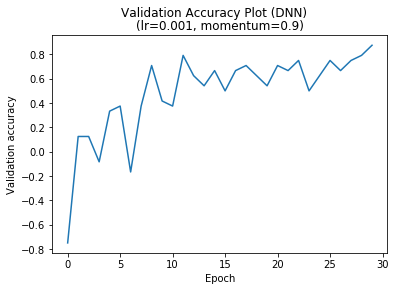

In [11]:
PLOT_PATH = f"./plots/validation_accuracy_plot_dnn_{CURRENT_TIME}.png"

title = "Validation Accuracy Plot (DNN)"
subtitle = f"(lr={LEARNING_RATE}, momentum={MOMENTUM})"

plt.plot(accuracy_history)
plt.suptitle(title)
plt.title(subtitle)
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")

plt.savefig(PLOT_PATH)
plt.show()

## 4. Test the model

In [9]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0
)

In [12]:
correct_case_count = 0

for case, sample in enumerate(iter(test_loader)):
    image, label = sample
    image = image.to(device)
    label = int(label)
    print(image.shape)
    break
    predict = model(image)
    predict = predict.data[0]
    
    #-- Logger --#
    print(f"[Test Case {case}]")
    print(f"\t[Prediction] {float(predict[0]) : .5f} : {float(predict[1]) : .5f}")
    print(f"\t[Real output] {label}")
    
    if label == 1 and float(predict[0]) < float(predict[1]):
        correct_case_count += 1
        print(f"\t[Result] Correct")
    elif label == 0 and float(predict[0]) > float(predict[1]):
        correct_case_count += 1
        print(f"\t[Result] Correct")
    else:
        print(f"\t[Result] Incorrect")
    #-- Logger --#
    
print(f"[Total Test Accuracy] {correct_case_count/test_data_num : .5f}")

torch.Size([1, 3072])
[Total Test Accuracy]  0.00000
